Test GN model-enhanced GPs for robustness to extreme points. 
Perturb a given SNR value and observe the difference between the physical model-enhanced GP and the normal GP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [4]:
down_sample_factor = 2
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [5]:
len(pch)

12

Add a large perturbation to one of the points to see if the physical model-enhanced GP is more robust to it.

In [6]:
#per_ind = 7
#per_ind = 19
per_ind = 8
snr[per_ind] = snr[per_ind] - 1

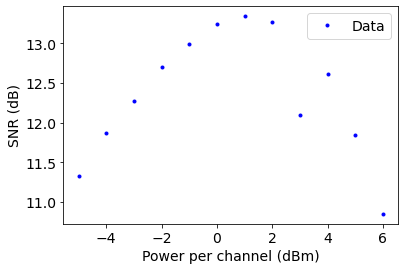

In [7]:
plt.plot(pch, snr, 'b.', label='Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [8]:
def shift_pch(pch, emp_pk):
    pch_gn = np.linspace(pch[0], pch[-1], 100)
    pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
    return pch_shifted
def gen_phys_targets(model, pch, num_pts_phys):
    pch_gn_shifted = np.linspace(pch[0], pch[-1], num_pts_phys)
    snr_phys = (model.predict_snr(pch_gn_shifted)).reshape(-1,1)
    return pch_gn_shifted, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR [dB] 

In [9]:
#phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.18, 35, 40.2, 50, 5.5, 10, 16.5)
phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.18, 35, 40.2, 50, 4.3, 10, 16, 0.04, 4)
#phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.174, 35, 40.2, 50, 5.2, 10, 16)

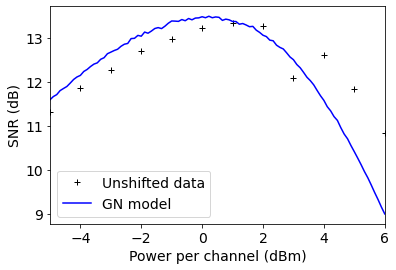

In [10]:
pch_gn = np.linspace(pch[0], pch[-1], 100)
snr_phys_us = phys_model.predict_snr(pch_gn).reshape(-1,1)
plt.plot(pch, snr, 'k+', label='Unshifted data')
plt.plot(pch_gn, snr_phys_us, 'b-', label='GN model')
plt.xlim([pch_gn[0], pch_gn[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [11]:
pch_gn = np.linspace(pch[0], pch[-1], 100)
emp_pk = 1.2
pch_fit_shifted = shift_pch(pch, emp_pk)
pch_shifted = shift_pch(pch, emp_pk)
snr_phys = phys_model.predict_snr(pch_shifted)
# pch_fit_shifted = pch_fit - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
# pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
# snr_phys = phys_model.predict_snr(pch_fit_shifted)
# print((emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))]))

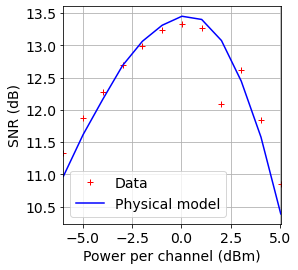

In [13]:
f, ax = plt.subplots()
plt.plot(pch_shifted, snr, 'r+', label='Data')
plt.plot(pch_shifted, snr_phys, 'b-', label='Physical model')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.yticks([10,10.5,11,11.5,12, 12.5, 13, 13.5])
#plt.ylim([12, 13.6])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.grid()
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Need to think about how many datapoints I will use for the physical model - ideally dont want to use the same number of datapoints as the data as then we dont get the benefit for a low number of points... 

In [17]:
np.random.seed(2)
num_points_phys = 20
#pch_test = np.linspace(pch_fit_shifted[0], pch_fit_shifted[-1], 50).reshape(-1,1) 
pch_test = np.linspace(pch_shifted[0], pch_shifted[-1], num_points_phys)
#snr_phys_test = phys_model.predict_snr(pch_test).reshape(-1,1)
snr_phys_test = phys_model.predict_snr(pch_test).reshape(-1,1)

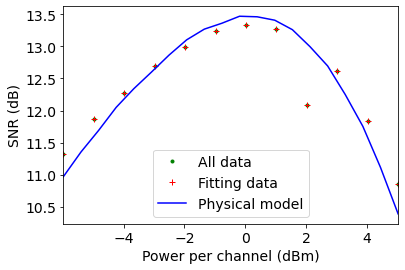

In [18]:
#plt.plot(pch_shifted[-9:], snr[-9:], 'g.', label='All data')
plt.plot(pch_shifted, snr, 'g.', label='All data')
plt.plot(pch_shifted, snr, 'r+', label='Fitting data')
plt.plot(pch_test, snr_phys_test, 'b-', label='Physical model')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [23]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_shifted, pch_test, snr, snr_phys_test, pch_shifted)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [24]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_shifted, snr, pch_shifted)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

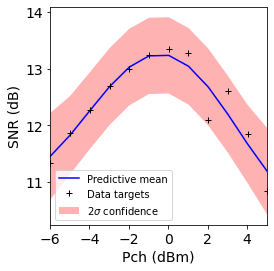

In [25]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'Predictive mean')
ax.plot(pch_shifted, snr,'k+', label = 'Data targets')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/robust_standard_gp.pdf', dpi=200,bbox_inches='tight')
plt.show()

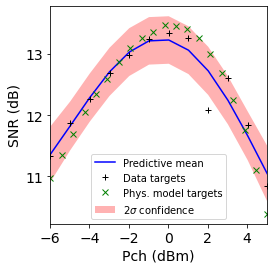

In [26]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'Predictive mean')
ax.plot(pch_shifted, snr,'k+', label = 'Data targets')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/robust_gn_enhanced_gp.pdf', dpi=200,bbox_inches='tight')
plt.show()

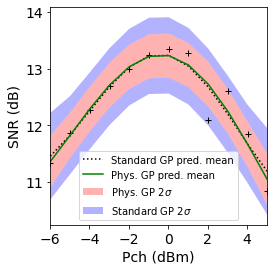

In [28]:
f, ax = plt.subplots()
#ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'Predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_shifted, mu_sk, 'k:', label = 'Standard GP pred. mean')
ax.plot(pch_shifted, mu_sk_phys, 'g-', label = 'Phys. GP pred. mean')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='Phys. GP 2$\sigma$')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_p2_phys)[::-1]]),
            alpha=0.3, fc='b', ec='None', label='Standard GP 2$\sigma$')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_n2_phys,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='b', ec='None')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('figures/robust_model_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

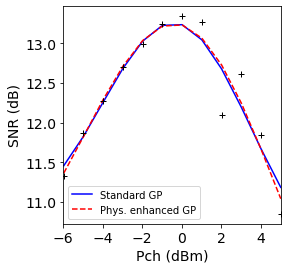

In [29]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'Standard GP')
ax.plot(pch_shifted, mu_sk_phys, 'r--', label = 'Phys. enhanced GP')
#ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_shifted, snr,'k+')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Predictive mean comparison")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/robust_pred_mean_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

**Observations:**
* The physical model changes the way the GP *interprets* the perturbed point
* The standard GP increases the predictive variance to accomodate for this point, resulting in inaccurate characterisation of the noise level and a deviation of the predictive mean
* The physics-enhanced GP uses a priori knowledge of the physics of the system to identify this outlier point as an outlier - the predictive variance of the model is not increased significantly to accomodate this point
* Note that we had to add AWGN with $\sigma = 0.03$ dB to the GN model predictions in order to prevent overfitting

In [30]:
max(std_sk)

array([0.38168167])

In [31]:
max(std_sk_phys)

array([0.22720893])

Relative change in the predictive std (%):

In [32]:
100*(max(std_sk_phys) - max(std_sk))/max(std_sk)

array([-40.47161459])

Drop in predictive std due to change in interpretation of outlier point!

RMSD of the predictive mean of the model with and without physical models:

In [33]:
np.mean(((mu_sk - mu_sk_phys)**2)**0.5)

0.03695255061322925

Mean relative difference (%):

In [34]:
np.mean(100*(mu_sk - mu_sk_phys)/mu_sk)

0.06143543980189858

In [35]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([3.7045919 , 4.51233428, 0.15454719])

In [36]:
np.exp(theta_phys)

array([14.05088655,  6.33965296,  0.05176734])